In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
# Đường dẫn đến các tập dữ liệu
usd_data_path = '/content/drive/MyDrive/dataset/US Dollar Index Futures Historical Data.csv'
bitcoin_data_path = '/content/drive/MyDrive/dataset/Bitcoin Historical Data.csv'
nasdaq_data_path = '/content/drive/MyDrive/dataset/NASDAQ Composite Historical Data.csv'

In [29]:
# Define a function to preprocess each dataset
def preprocess_data(data_path, date_format='%d/%m/%Y'):
  df = pd.read_csv(data_path)
  df = df[::-1] # Reverse the order
  df.fillna(method='ffill', inplace=True)
  df['Price'] = df['Price'].str.replace(',', '').astype(float)
  df['Date'] = pd.to_datetime(df['Date'], format=date_format)
  return df

In [30]:
# Define a function to preprocess each dataset
def preprocess_us_data(data_path, date_format='%m/%d/%Y'):
    df = pd.read_csv(data_path)
    df = df[::-1]  # Reverse the order
    df.fillna(method='ffill', inplace=True)
    df['Date'] = pd.to_datetime(df['Date'], format=date_format)
    return df

In [31]:
# Preprocess each dataset
bitcoin_df = preprocess_data(bitcoin_data_path)
nasdaq_df = preprocess_data(nasdaq_data_path)
usd_df = preprocess_us_data(usd_data_path)

# DATASET BITCOIN

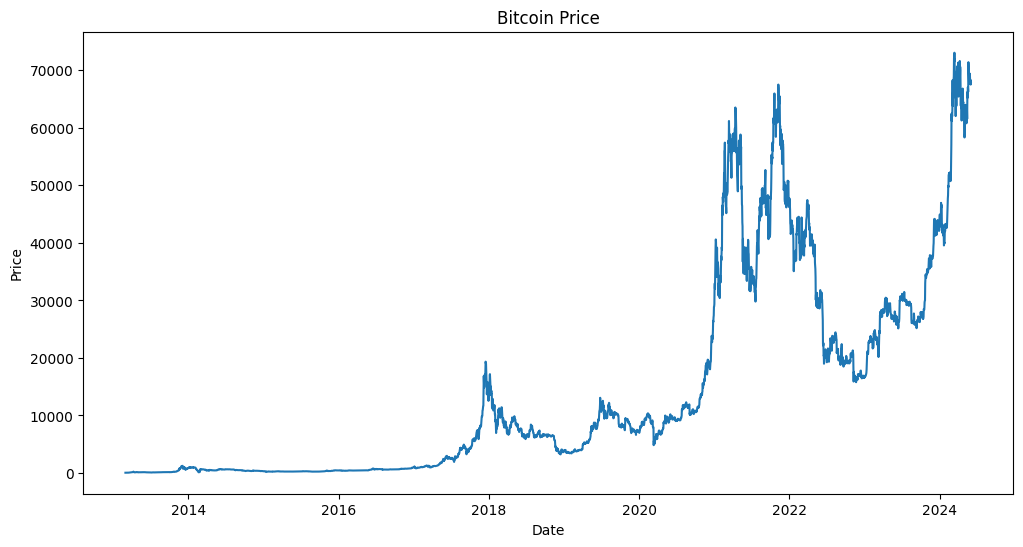

In [32]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(bitcoin_df['Date'], bitcoin_df['Price'])
plt.title('Bitcoin Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# DATASET NASDAQ


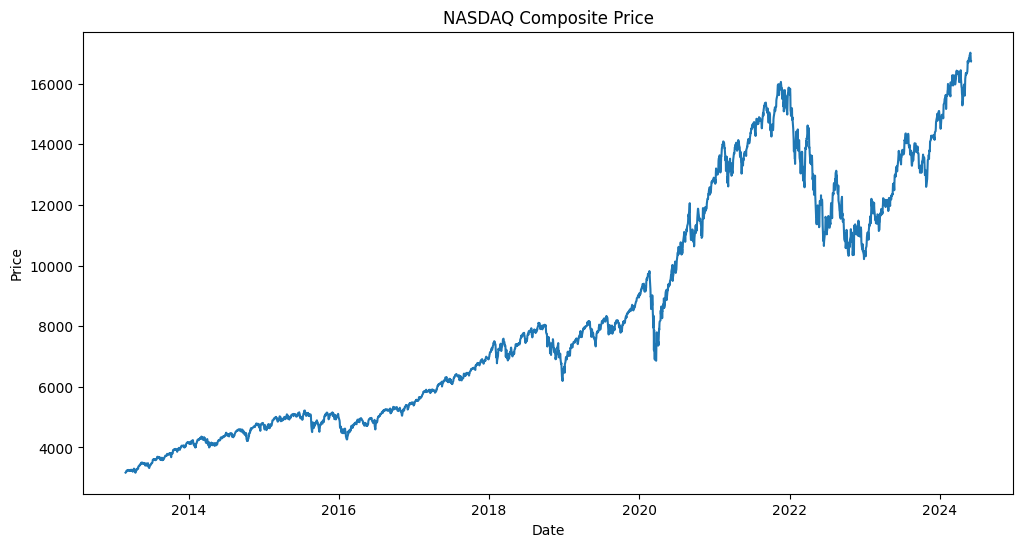

In [33]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(nasdaq_df['Date'], nasdaq_df['Price'])
plt.title('NASDAQ Composite Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# DATASET US Dollar Index

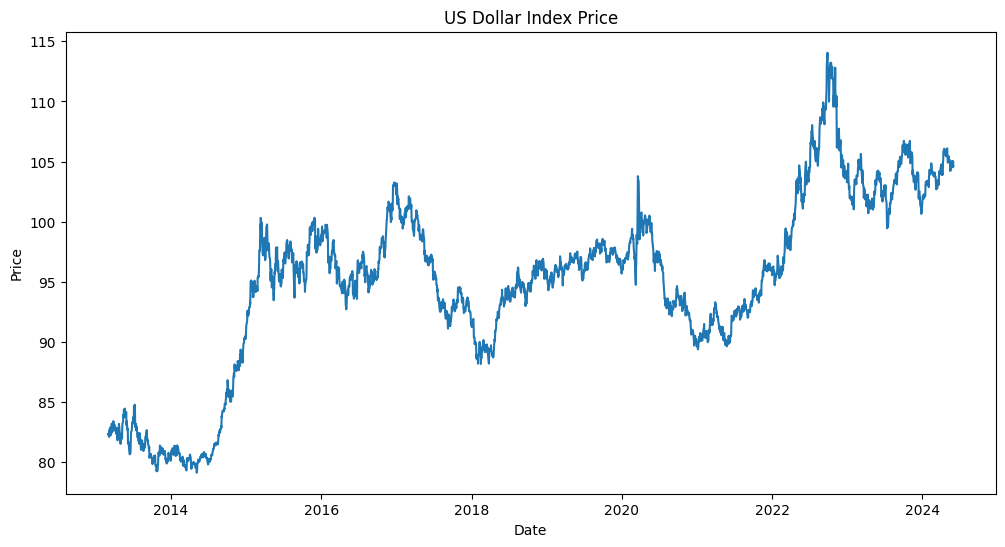

In [34]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(usd_df['Date'], usd_df['Price'])
plt.title('US Dollar Index Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [35]:
# Function to create sequences
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:i+sequence_length]
        y = data[i+sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [36]:
# Function to forecast future prices
def forecast_future(model, data, steps, scaler, sequence_length=30):
    last_sequence = data[-sequence_length:].reshape(1, sequence_length, 1)
    forecast = []
    for _ in range(steps):
        prediction = model.predict(last_sequence)
        forecast.append(prediction[0, 0])
        last_sequence = np.roll(last_sequence, -1, axis=1)
        last_sequence[0, -1, 0] = prediction[0, 0]

    forecast = np.array(forecast).reshape(-1, 1)
    forecast_prices = scaler.inverse_transform(forecast)
    return forecast_prices.flatten()

In [37]:
# Function to split data into training and testing sets
def split_data(X, y, ratio):
    train_size = int(len(X) * ratio)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    return X_train, X_test, y_train, y_test

In [38]:
# Function to build the LSTM model
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))
    return model

In [39]:
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, mape, rmse

In [40]:
# Function to process the dataset and plot the results
def process_dataset(df, dataset_name, sequence_length=30, split_ratio=0.8):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[['Price']].values)
    X, y = create_sequences(scaled_data, sequence_length)
    X_train, X_test, y_train, y_test = split_data(X, y, split_ratio)

    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_model(input_shape)
    model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.1, verbose=1)

    # Predictions
    predicted_prices = model.predict(X_test)

    # Inverse transform to get actual prices
    actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    predicted_prices_actual = scaler.inverse_transform(predicted_prices).flatten()

    # Evaluation
    mae, mape, rmse = evaluate_model(actual_prices, predicted_prices_actual)

    # Forecast future prices
    future_steps = 30
    future_forecast_1 = forecast_future(model, scaled_data, future_steps, scaler)
    future_forecast_2 = forecast_future(model, scaler.transform(future_forecast_1.reshape(-1, 1)), future_steps, scaler)
    future_forecast_3 = forecast_future(model, scaler.transform(future_forecast_2.reshape(-1, 1)), future_steps, scaler)

    # Plot results
    plt.figure(figsize=(14, 7))
    plt.plot(df['Date'], df['Price'], color='blue', label='Training Data', linestyle='solid')
    plt.plot(df['Date'][len(df) - len(y_test):], actual_prices, color='orange', label='Actual Price', linestyle='solid')
    plt.plot(df['Date'][len(df) - len(y_test):], predicted_prices_actual, color='green', label='Predicted Price', linestyle='solid')

    future_dates_1 = pd.date_range(df['Date'].iloc[-1], periods=future_steps + 1)[1:]
    future_dates_2 = pd.date_range(future_dates_1[-1], periods=future_steps + 1)[1:]
    future_dates_3 = pd.date_range(future_dates_2[-1], periods=future_steps + 1)[1:]

    plt.plot(future_dates_1, future_forecast_1, color='red', label='Next 30 Days Forecast', linestyle='solid')
    plt.plot(future_dates_2, future_forecast_2, color='yellow', label='Next 60 Days Forecast', linestyle='solid')
    plt.plot(future_dates_3, future_forecast_3, color='brown', label='Next 90 Days Forecast', linestyle='solid')

    plt.title(f'LSTM {dataset_name} Time Series Forecast Ratio {round(split_ratio * 10)}:{round((1 - split_ratio) * 10)}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    return {'mae': mae, 'rmse': rmse, 'mape': mape}

# BITCOIN

# RATIO 6:4

Epoch 1/100
35/35 [==============================] - 13s 140ms/step - loss: 5.3037e-04 - val_loss: 2.2861e-04
Epoch 2/100
35/35 [==============================] - 2s 70ms/step - loss: 1.0272e-04 - val_loss: 1.9667e-04
Epoch 3/100
35/35 [==============================] - 2s 66ms/step - loss: 9.0508e-05 - val_loss: 1.7157e-04
Epoch 4/100
35/35 [==============================] - 3s 73ms/step - loss: 8.7742e-05 - val_loss: 1.6043e-04
Epoch 5/100
35/35 [==============================] - 4s 108ms/step - loss: 8.0122e-05 - val_loss: 1.5974e-04
Epoch 6/100
35/35 [==============================] - 3s 86ms/step - loss: 7.6279e-05 - val_loss: 1.8357e-04
Epoch 7/100
35/35 [==============================] - 2s 70ms/step - loss: 6.6528e-05 - val_loss: 2.2816e-04
Epoch 8/100
35/35 [==============================] - 2s 68ms/step - loss: 6.1901e-05 - val_loss: 1.1792e-04
Epoch 9/100
35/35 [==============================] - 2s 70ms/step - loss: 5.9181e-05 - val_loss: 2.0959e-04
Epoch 10/100
35/35 [=====

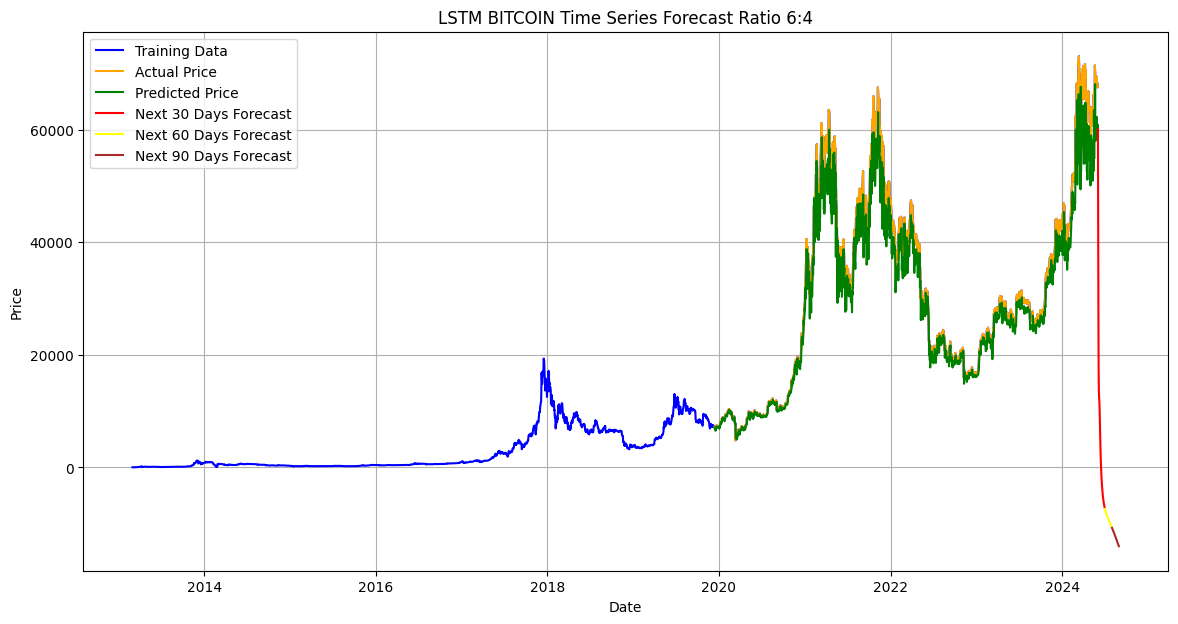

Testing MAE: 2369.7432
Testing RMSE: 3573.1307
Testing MAPE: 6.02%


In [41]:
results = process_dataset(bitcoin_df, "BITCOIN", 30, 0.6)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# RATIO 7:3

Epoch 1/100
41/41 [==============================] - 11s 136ms/step - loss: 6.7473e-04 - val_loss: 8.4856e-04
Epoch 2/100
41/41 [==============================] - 3s 82ms/step - loss: 1.0809e-04 - val_loss: 0.0022
Epoch 3/100
41/41 [==============================] - 3s 69ms/step - loss: 9.6020e-05 - val_loss: 0.0012
Epoch 4/100
41/41 [==============================] - 3s 68ms/step - loss: 8.1176e-05 - val_loss: 0.0017
Epoch 5/100
41/41 [==============================] - 3s 74ms/step - loss: 8.1229e-05 - val_loss: 9.7722e-04
Epoch 6/100
41/41 [==============================] - 4s 109ms/step - loss: 7.2202e-05 - val_loss: 0.0012
Epoch 7/100
41/41 [==============================] - 3s 69ms/step - loss: 6.5961e-05 - val_loss: 7.2485e-04
Epoch 8/100
41/41 [==============================] - 3s 70ms/step - loss: 6.6745e-05 - val_loss: 0.0012
Epoch 9/100
41/41 [==============================] - 3s 69ms/step - loss: 5.9337e-05 - val_loss: 0.0014
Epoch 10/100
41/41 [=============================

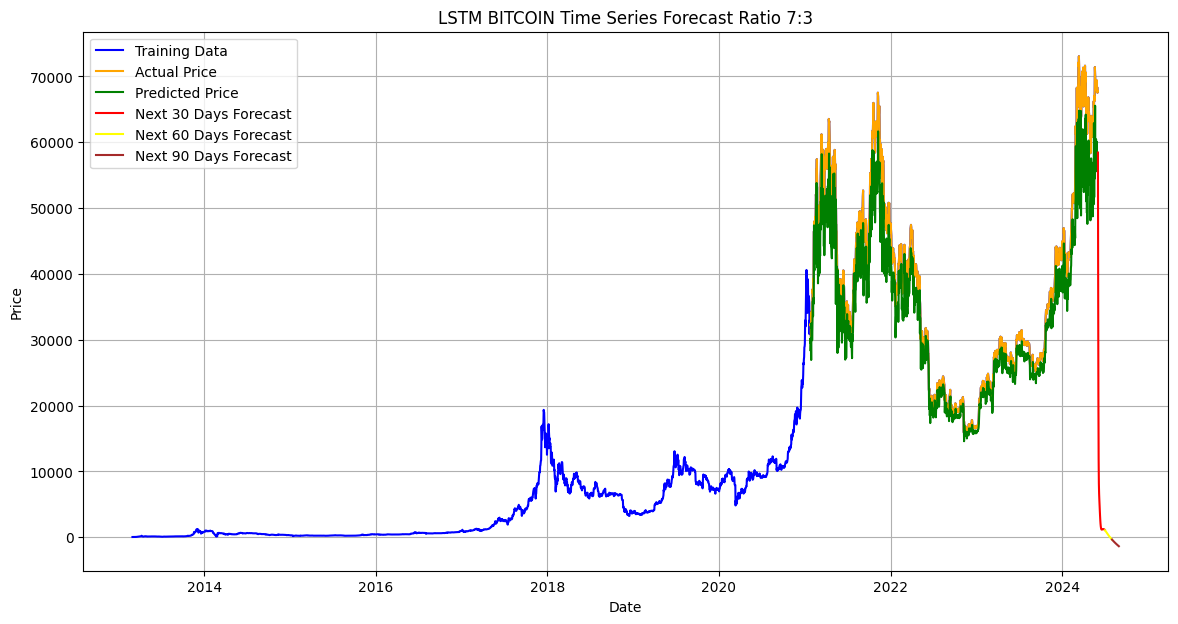

Testing MAE: 3731.8111
Testing RMSE: 4926.0457
Testing MAPE: 8.72%


In [42]:
results = process_dataset(bitcoin_df, "BITCOIN", 30, 0.7)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# RATIO 8:2

Epoch 1/100
46/46 [==============================] - 14s 103ms/step - loss: 0.0024 - val_loss: 0.0082
Epoch 2/100
46/46 [==============================] - 3s 71ms/step - loss: 3.6948e-04 - val_loss: 0.0117
Epoch 3/100
46/46 [==============================] - 4s 83ms/step - loss: 3.5951e-04 - val_loss: 0.0169
Epoch 4/100
46/46 [==============================] - 5s 106ms/step - loss: 3.2829e-04 - val_loss: 0.0058
Epoch 5/100
46/46 [==============================] - 3s 70ms/step - loss: 3.0933e-04 - val_loss: 0.0076
Epoch 6/100
46/46 [==============================] - 3s 70ms/step - loss: 2.8183e-04 - val_loss: 0.0063
Epoch 7/100
46/46 [==============================] - 3s 73ms/step - loss: 2.5251e-04 - val_loss: 0.0093
Epoch 8/100
46/46 [==============================] - 5s 113ms/step - loss: 3.3519e-04 - val_loss: 0.0042
Epoch 9/100
46/46 [==============================] - 3s 70ms/step - loss: 2.7107e-04 - val_loss: 0.0032
Epoch 10/100
46/46 [==============================] - 3s 70ms/st

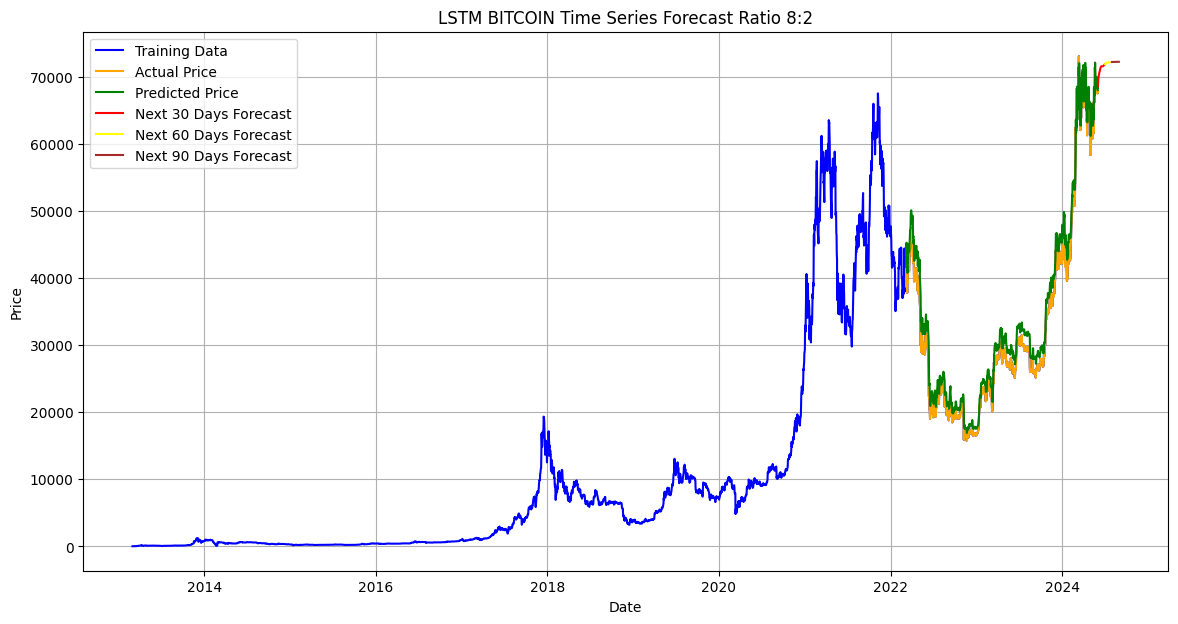

Testing MAE: 2011.2780
Testing RMSE: 2282.1476
Testing MAPE: 6.64%


In [43]:
results = process_dataset(bitcoin_df, "BITCOIN", 30, 0.8)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# NASDAQ

# RATIO 6:4

Epoch 1/100
24/24 [==============================] - 10s 155ms/step - loss: 0.0064 - val_loss: 5.3550e-04
Epoch 2/100
24/24 [==============================] - 3s 112ms/step - loss: 3.6265e-04 - val_loss: 3.7090e-04
Epoch 3/100
24/24 [==============================] - 2s 74ms/step - loss: 1.4526e-04 - val_loss: 2.7263e-04
Epoch 4/100
24/24 [==============================] - 2s 67ms/step - loss: 1.2212e-04 - val_loss: 2.2532e-04
Epoch 5/100
24/24 [==============================] - 2s 68ms/step - loss: 1.2401e-04 - val_loss: 2.7772e-04
Epoch 6/100
24/24 [==============================] - 2s 66ms/step - loss: 1.3499e-04 - val_loss: 2.6447e-04
Epoch 7/100
24/24 [==============================] - 2s 71ms/step - loss: 1.2686e-04 - val_loss: 2.7277e-04
Epoch 8/100
24/24 [==============================] - 2s 71ms/step - loss: 1.2920e-04 - val_loss: 2.5388e-04
Epoch 9/100
24/24 [==============================] - 2s 101ms/step - loss: 1.1416e-04 - val_loss: 2.1304e-04
Epoch 10/100
24/24 [========

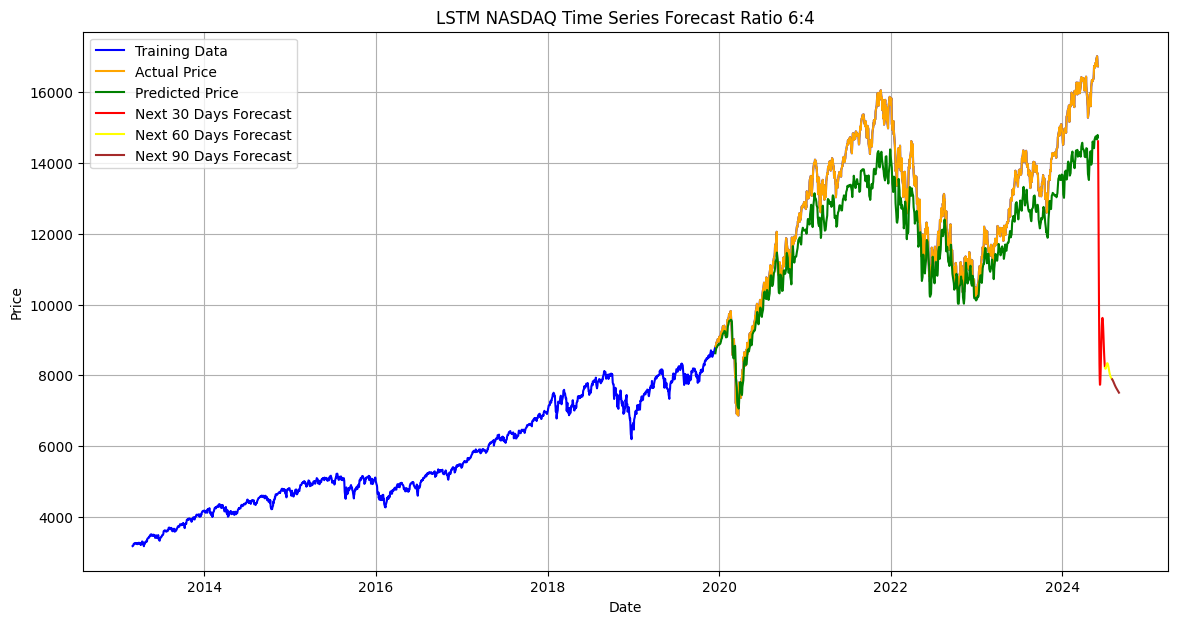

Testing MAE: 854.6381
Testing RMSE: 1013.1271
Testing MAPE: 6.26%


In [44]:
results = process_dataset(nasdaq_df, "NASDAQ", 30, 0.6)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# RATIO 7:3

Epoch 1/100
28/28 [==============================] - 12s 144ms/step - loss: 0.0052 - val_loss: 0.0062
Epoch 2/100
28/28 [==============================] - 2s 72ms/step - loss: 3.3721e-04 - val_loss: 0.0027
Epoch 3/100
28/28 [==============================] - 2s 70ms/step - loss: 2.3398e-04 - val_loss: 0.0013
Epoch 4/100
28/28 [==============================] - 2s 72ms/step - loss: 2.1941e-04 - val_loss: 0.0012
Epoch 5/100
28/28 [==============================] - 3s 95ms/step - loss: 2.1353e-04 - val_loss: 0.0015
Epoch 6/100
28/28 [==============================] - 3s 113ms/step - loss: 2.0551e-04 - val_loss: 9.9115e-04
Epoch 7/100
28/28 [==============================] - 2s 80ms/step - loss: 2.0731e-04 - val_loss: 0.0024
Epoch 8/100
28/28 [==============================] - 2s 70ms/step - loss: 1.9824e-04 - val_loss: 0.0022
Epoch 9/100
28/28 [==============================] - 2s 71ms/step - loss: 1.9223e-04 - val_loss: 0.0019
Epoch 10/100
28/28 [==============================] - 2s 68ms

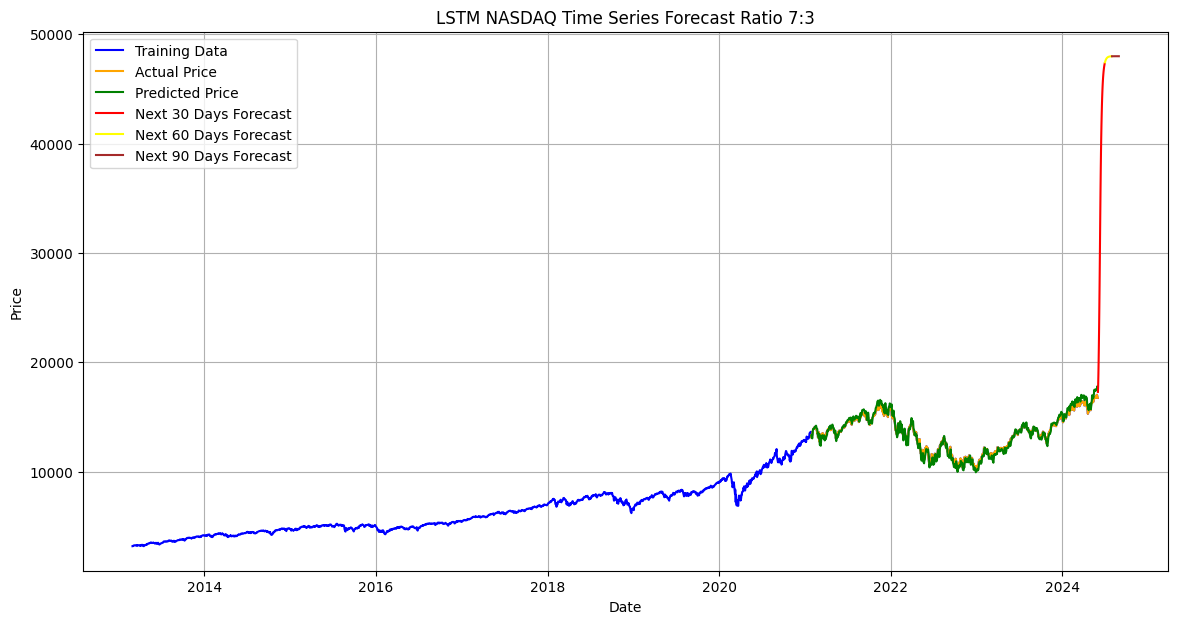

Testing MAE: 259.5191
Testing RMSE: 324.7240
Testing MAPE: 1.93%


In [45]:
results = process_dataset(nasdaq_df, "NASDAQ", 30, 0.7)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# RATIO 8:2

Epoch 1/100
32/32 [==============================] - 12s 195ms/step - loss: 0.0112 - val_loss: 0.0030
Epoch 2/100
32/32 [==============================] - 2s 73ms/step - loss: 4.4694e-04 - val_loss: 0.0013
Epoch 3/100
32/32 [==============================] - 2s 72ms/step - loss: 3.2496e-04 - val_loss: 0.0012
Epoch 4/100
32/32 [==============================] - 2s 73ms/step - loss: 3.2802e-04 - val_loss: 0.0013
Epoch 5/100
32/32 [==============================] - 2s 72ms/step - loss: 3.1120e-04 - val_loss: 0.0012
Epoch 6/100
32/32 [==============================] - 3s 106ms/step - loss: 3.1782e-04 - val_loss: 0.0016
Epoch 7/100
32/32 [==============================] - 3s 102ms/step - loss: 3.1878e-04 - val_loss: 0.0011
Epoch 8/100
32/32 [==============================] - 2s 72ms/step - loss: 2.9436e-04 - val_loss: 0.0011
Epoch 9/100
32/32 [==============================] - 2s 72ms/step - loss: 3.0345e-04 - val_loss: 0.0015
Epoch 10/100
32/32 [==============================] - 2s 70ms/st

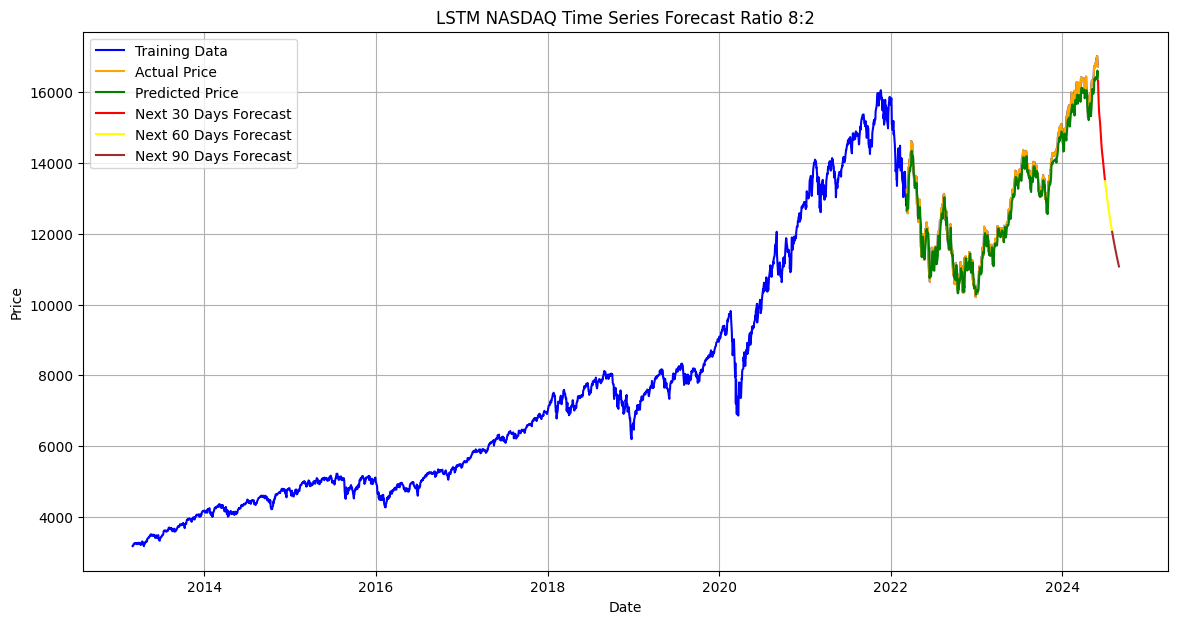

Testing MAE: 216.0724
Testing RMSE: 261.3153
Testing MAPE: 1.64%


In [46]:
results = process_dataset(nasdaq_df, "NASDAQ", 30, 0.8)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# US Dollar

# RATIO 6:4

Epoch 1/100
25/25 [==============================] - 10s 127ms/step - loss: 0.0284 - val_loss: 0.0025
Epoch 2/100
25/25 [==============================] - 2s 67ms/step - loss: 0.0026 - val_loss: 7.1017e-04
Epoch 3/100
25/25 [==============================] - 2s 76ms/step - loss: 0.0012 - val_loss: 3.0809e-04
Epoch 4/100
25/25 [==============================] - 3s 115ms/step - loss: 0.0011 - val_loss: 2.9932e-04
Epoch 5/100
25/25 [==============================] - 3s 104ms/step - loss: 0.0010 - val_loss: 2.9815e-04
Epoch 6/100
25/25 [==============================] - 2s 70ms/step - loss: 9.9344e-04 - val_loss: 3.4177e-04
Epoch 7/100
25/25 [==============================] - 2s 69ms/step - loss: 0.0010 - val_loss: 3.2136e-04
Epoch 8/100
25/25 [==============================] - 2s 73ms/step - loss: 9.5473e-04 - val_loss: 3.1928e-04
Epoch 9/100
25/25 [==============================] - 2s 70ms/step - loss: 0.0010 - val_loss: 3.9342e-04
Epoch 10/100
25/25 [==============================] - 2s

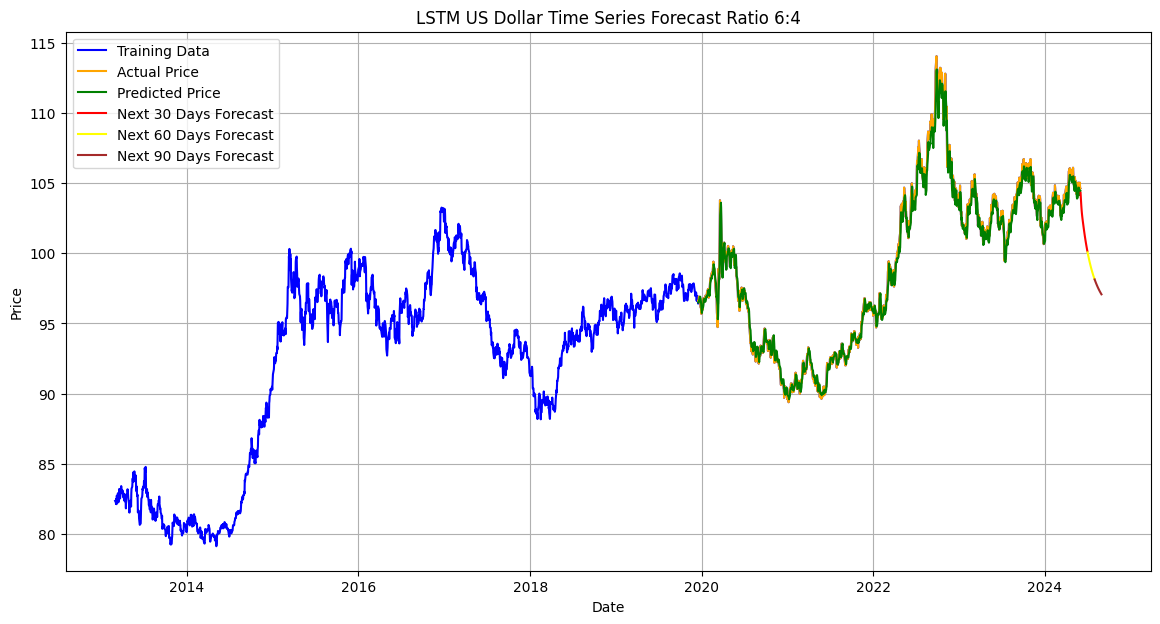

Testing MAE: 0.4326
Testing RMSE: 0.5757
Testing MAPE: 0.43%


In [47]:
results = process_dataset(usd_df, "US Dollar", 30, 0.6)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# RATIO 7:3

Epoch 1/100
29/29 [==============================] - 10s 121ms/step - loss: 0.0217 - val_loss: 0.0012
Epoch 2/100
29/29 [==============================] - 2s 69ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 3/100
29/29 [==============================] - 3s 94ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 4/100
29/29 [==============================] - 3s 117ms/step - loss: 0.0010 - val_loss: 7.4221e-04
Epoch 5/100
29/29 [==============================] - 2s 71ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 6/100
29/29 [==============================] - 2s 68ms/step - loss: 9.7189e-04 - val_loss: 0.0014
Epoch 7/100
29/29 [==============================] - 2s 70ms/step - loss: 9.5495e-04 - val_loss: 0.0012
Epoch 8/100
29/29 [==============================] - 2s 68ms/step - loss: 9.7934e-04 - val_loss: 9.8388e-04
Epoch 9/100
29/29 [==============================] - 2s 69ms/step - loss: 9.6865e-04 - val_loss: 8.3724e-04
Epoch 10/100
29/29 [==============================] - 3s 109ms/step -

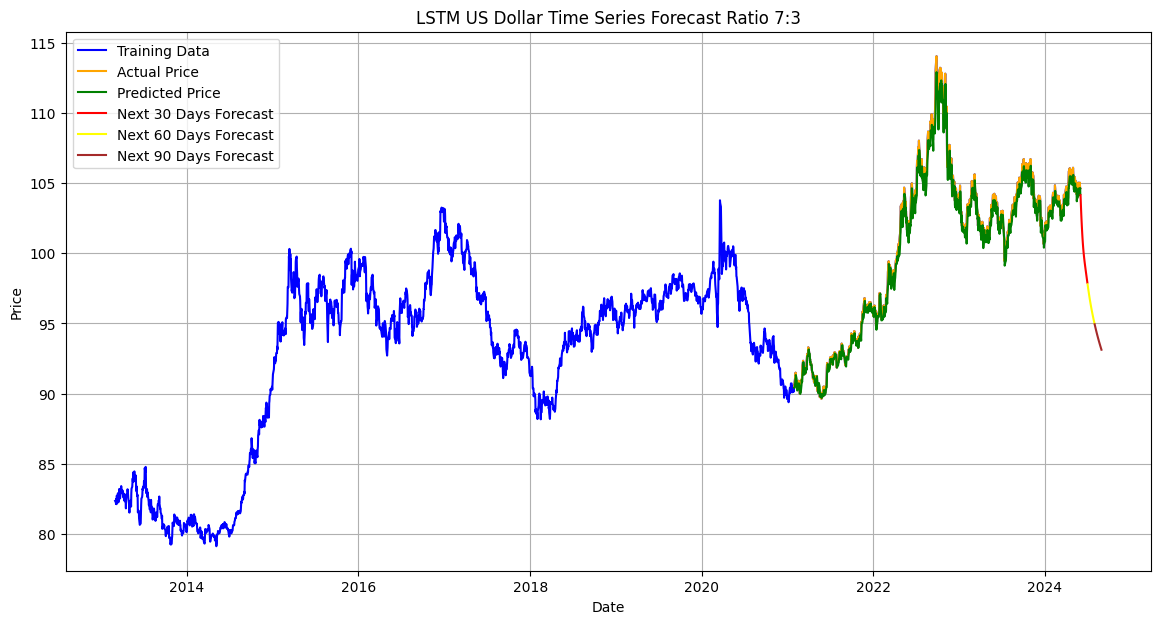

Testing MAE: 0.4706
Testing RMSE: 0.6156
Testing MAPE: 0.46%


In [48]:
results = process_dataset(usd_df, "US Dollar", 30, 0.7)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# RATIO 8:2

Epoch 1/100
33/33 [==============================] - 11s 109ms/step - loss: 0.0249 - val_loss: 0.0015
Epoch 2/100
33/33 [==============================] - 2s 67ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 3/100
33/33 [==============================] - 2s 70ms/step - loss: 0.0011 - val_loss: 5.9895e-04
Epoch 4/100
33/33 [==============================] - 3s 88ms/step - loss: 0.0010 - val_loss: 5.8985e-04
Epoch 5/100
33/33 [==============================] - 4s 110ms/step - loss: 9.9845e-04 - val_loss: 5.7774e-04
Epoch 6/100
33/33 [==============================] - 2s 70ms/step - loss: 9.6328e-04 - val_loss: 6.4513e-04
Epoch 7/100
33/33 [==============================] - 2s 71ms/step - loss: 9.4404e-04 - val_loss: 6.4590e-04
Epoch 8/100
33/33 [==============================] - 2s 70ms/step - loss: 9.3608e-04 - val_loss: 5.2450e-04
Epoch 9/100
33/33 [==============================] - 2s 68ms/step - loss: 9.5486e-04 - val_loss: 5.3878e-04
Epoch 10/100
33/33 [=============================

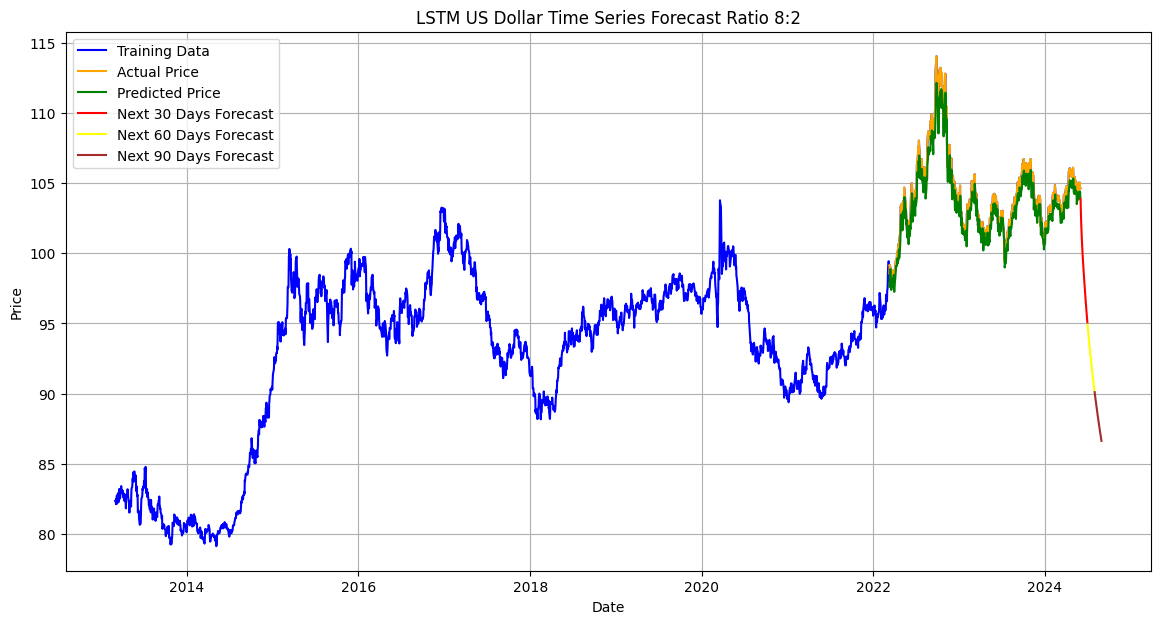

Testing MAE: 0.7397
Testing RMSE: 0.8906
Testing MAPE: 0.70%


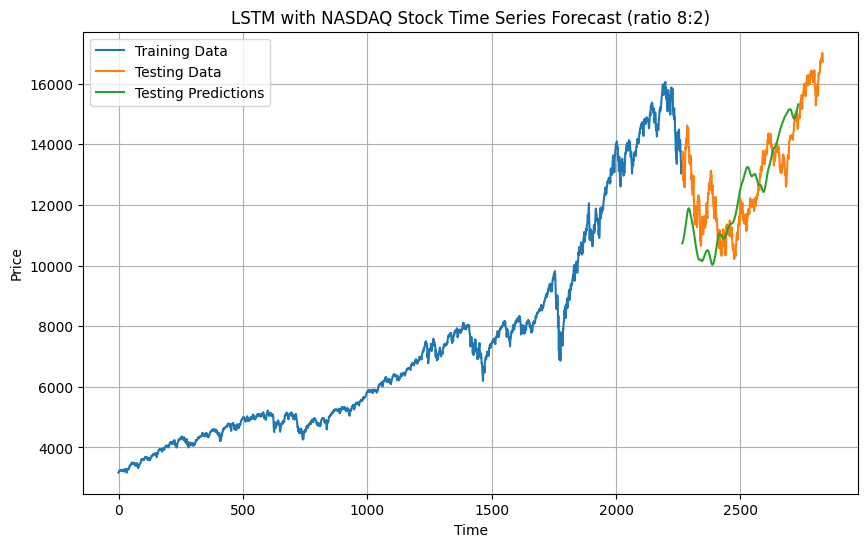

16/16 [==============================] - 1s 37ms/step
USD Training RMSE: 2.078438178915611
USD Testing RMSE: 5.240843601367516
USD Evaluation:
MAE: 4.931428925067062, MAPE: 4.677387372663501, RMSE: 5.240843601367516


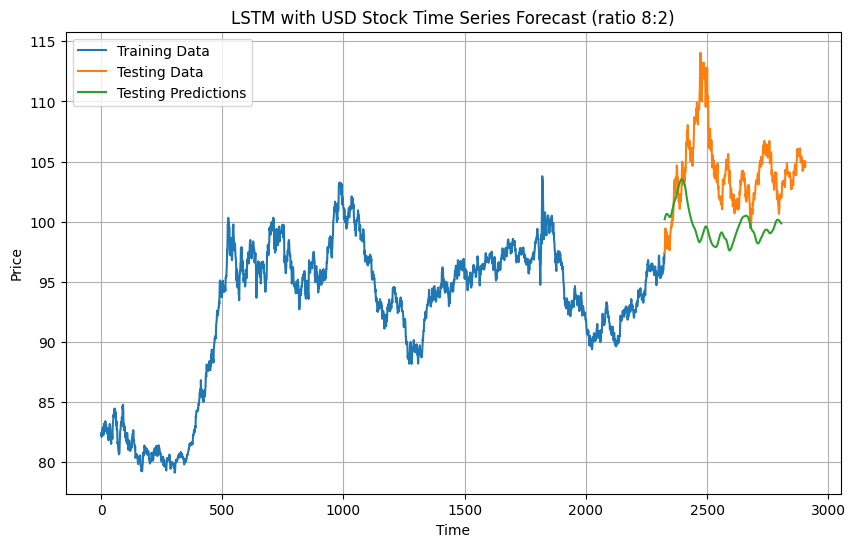

In [49]:
results = process_dataset(usd_df, "US Dollar", 30, 0.8)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')